<a href="https://colab.research.google.com/github/MC-intel/fi-sci/blob/main/Forecasting_Equity_Correlations_with_Hybrid_Transformer_Graph_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running on: cpu
Fetching live data for Multi-Agent Environment: ['NVDA', 'AMD', 'INTC', 'MSFT', 'GOOGL', 'AAPL', 'TSLA', 'AMZN']...


/tmp/ipython-input-3933454838.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period="6mo", interval="1d", progress=False)['Close']


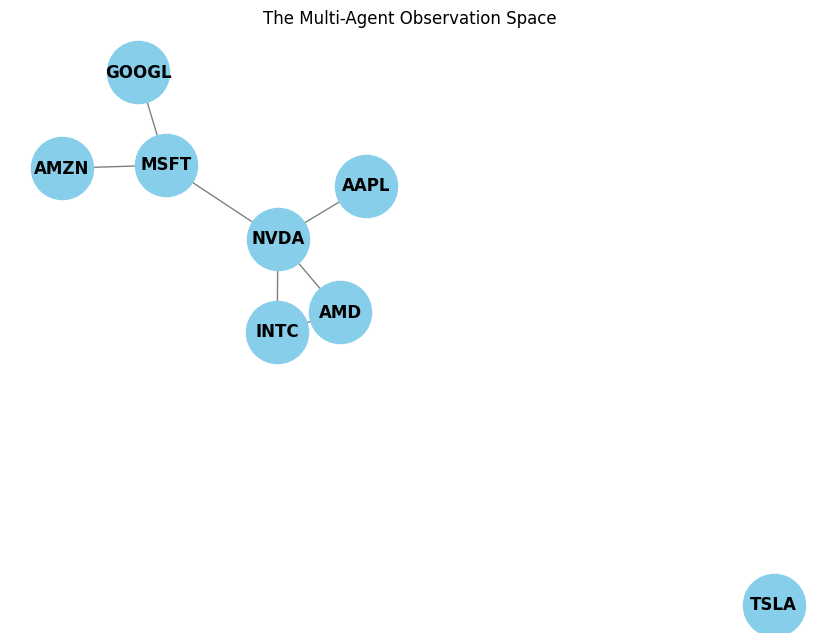


--- AGENT WORLD MODEL OUTPUT (Predicted Next State) ---
AGENT      | PREDICTED SIGNAL
------------------------------
NVDA       | 0.0423
AMD        | 0.0551
INTC       | 0.0551
MSFT       | 0.0384
GOOGL      | 0.0469
AAPL       | 0.0301
TSLA       | 0.0640
AMZN       | -0.0070

[RESEARCH NOTE]: In a full RL setup, these embeddings (before the head)
would be the input state for your PPO Actor-Critic network.


In [ ]:


# @title 1. Install & Setup (Run this first)
# Installs PyTorch Geometric for the Graph Neural Network
!pip install -q yfinance torch_geometric

import yfinance as yf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Use GPU if available (AMD/NVIDIA friendly)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on: {device}")


# @title 2. The "Multi-Agent" Market Graph
# We treat the market not as a list, but as a Graph of interacting agents.
# Nodes = Stocks (Agents)
# Edges = Correlations/Sectors (Communication channels)

tickers = ['NVDA', 'AMD', 'INTC', 'MSFT', 'GOOGL', 'AAPL', 'TSLA', 'AMZN']
print(f"Fetching live data for Multi-Agent Environment: {tickers}...")
data = yf.download(tickers, period="6mo", interval="1d", progress=False)['Close']
returns = data.pct_change().dropna()

# Normalize data for the Neural Net
tensor_data = torch.tensor(returns.values, dtype=torch.float32).to(device)

# --- DEFINE THE GRAPH STRUCTURE ---
# In a real RL env, this would be dynamic. Here we hardcode the "Sector" logic.
# 0:NVDA, 1:AMD, 2:INTC (Chips)
# 3:MSFT, 4:GOOGL (Cloud)
# 5:AAPL (Consumer/Chips), 6:TSLA, 7:AMZN
edge_index = torch.tensor([
    [0, 1], [1, 0], # NVDA <-> AMD
    [1, 2], [2, 1], # AMD <-> INTC
    [0, 2], [2, 0], # NVDA <-> INTC
    [3, 4], [4, 3], # MSFT <-> GOOGL
    [5, 0], [0, 5], # AAPL <-> NVDA (Supply Chain)
    [3, 0], [0, 3], # MSFT <-> NVDA (AI Partner)
    [7, 3], [3, 7]  # AMZN <-> MSFT (Cloud Rivals)
], dtype=torch.long).t().contiguous().to(device) # Transpose to [2, num_edges] for PyG

def visualize_graph():
    plt.figure(figsize=(8, 6))
    G = nx.Graph()
    for i, t in enumerate(tickers): G.add_node(t)
    # Convert edges from [2, num_edges] to [num_edges, 2] for plotting iteration
    edges_list = edge_index.cpu().t().numpy()
    for u, v in edges_list:
        G.add_edge(tickers[u], tickers[v])

    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color='skyblue',
            node_size=2000, font_weight='bold', edge_color='gray')
    plt.title("The Multi-Agent Observation Space")
    plt.show()

visualize_graph()


# @title 3. The Hybrid World Model (Transformer + GNN)
# This mimics the architecture in the paper:
# 1. Transformer encodes the history of ONE agent.
# 2. GNN lets agents "talk" to neighbors to update their state.

class MultiAgentWorldModel(nn.Module):
    def __init__(self, window_size, d_model=32):
        super().__init__()

        # A. Temporal Encoder (The "Memory" of each Agent)
        self.input_proj = nn.Linear(window_size, d_model)
        self.transformer = nn.TransformerEncoderLayer(d_model=d_model, nhead=4, batch_first=True)

        # B. Spatial Encoder (The "Communication" between Agents)
        # Graph Attention Network (GAT) - learns WHICH neighbor matters most
        self.gat = GATConv(d_model, d_model, heads=1)

        # C. Policy Head (Predicting the next state)
        self.head = nn.Linear(d_model, 1)

    def forward(self, x, edge_index):
        # x shape: [Batch(Days), Num_Agents] -> We transpose to handle agents
        # For this demo, we treat the 'batch' as the time window for simplicity
        # Input: [Num_Agents, Window_Size]

        # 1. Temporal Pass (Agents think about their own history)
        x = self.input_proj(x) # [Num_Agents, d_model]
        # Transformer usually needs sequence, here we treat window as features for simplicity
        # or expand dims if using full seq-to-seq. We'll keep it simple:
        x = x.unsqueeze(1) # [Num_Agents, 1, d_model]
        x = self.transformer(x).squeeze(1) # [Num_Agents, d_model]

        # 2. Spatial Pass (Agents talk to neighbors)
        # This is where NVDA 'tells' AMD about the market crash
        x = F.relu(self.gat(x, edge_index))

        # 3. Output Observation (Predicted Next Return)
        return self.head(x)

# --- RUN THE SIMULATION ---
WINDOW = 20
model = MultiAgentWorldModel(window_size=WINDOW).to(device)

# Grab the last 20 days of data for all agents
# Shape: [Num_Agents, 20]
current_state = tensor_data[-WINDOW:].T

with torch.no_grad():
    prediction = model(current_state, edge_index)

print("\n--- AGENT WORLD MODEL OUTPUT (Predicted Next State) ---")
print(f"{'AGENT':<10} | {'PREDICTED SIGNAL':<15}")
print("-" * 30)
for i, val in enumerate(prediction):
    print(f"{tickers[i]:<10} | {val.item():.4f}")

print("\n[RESEARCH NOTE]: In a full RL setup, these embeddings (before the head)")
print("would be the input state for your PPO Actor-Critic network.")


--- 1. FETCHING DATA FOR 8 ASSETS ---


/tmp/ipython-input-3820233177.py:53: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKERS + [BENCHMARK], period="1y", interval="1d", progress=False)['Close']


Data Shape (Days, Stocks, Features): torch.Size([251, 8, 3])
--- STARTING BACKTEST (Last 60 Days) ---
Training Model... Done.
Simulating Trades...


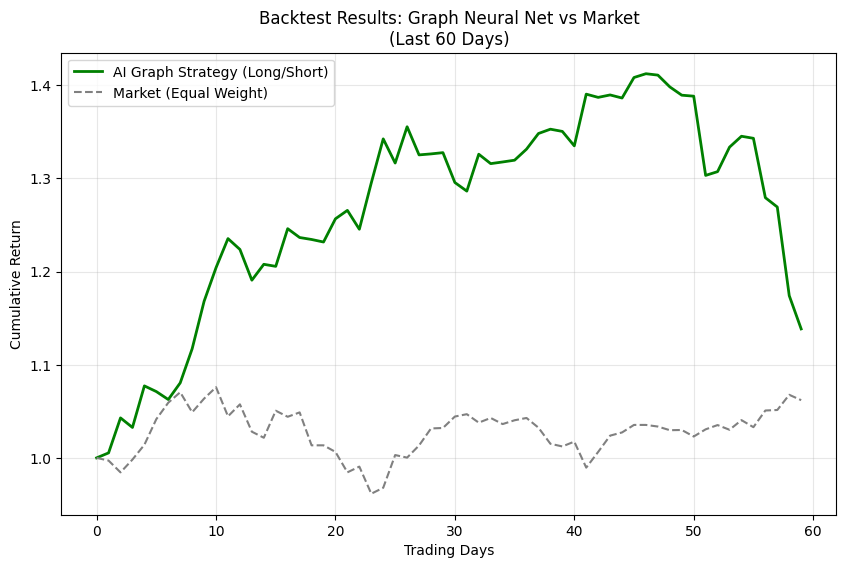

Final Strategy Return: 13.84%
Note: If the Green line is going up while Gray is flat/down, you have 'Alpha'.


In [ ]:
# @title 1. Setup & Data Engineering (The "Alpha" Source)

!pip install -q yfinance torch_geometric matplotlib pandas numpy



import yfinance as yf

import torch

import torch.nn as nn

import torch.nn.functional as F

from torch_geometric.nn import GATConv

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt



# Use GPU if available

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# --- CONFIGURATION ---

TICKERS = ['NVDA', 'AMD', 'INTC', 'MSFT', 'GOOGL', 'AAPL', 'TSLA', 'AMZN']

# Benchmarking against an ETF to prove we beat the market

BENCHMARK = 'QQQ'

LOOKBACK_WINDOW = 30  # Model sees last 30 days

TEST_DAYS = 60        # Backtest over the last 60 trading days

EPOCHS = 100          # Training iterations

LR = 0.001



print(f"--- 1. FETCHING DATA FOR {len(TICKERS)} ASSETS ---")

# Get data

data = yf.download(TICKERS + [BENCHMARK], period="1y", interval="1d", progress=False)['Close']



# --- FEATURE ENGINEERING ---

# The paper uses more than just price. We add Volatility & Momentum.

returns = data.pct_change().fillna(0)

volatility = returns.rolling(window=5).std().fillna(0) # 5-day volatility

momentum = returns.rolling(window=10).mean().fillna(0) # 10-day trend



# Stack features: [Time, Stocks, Features=3] (Return, Vol, Mom)

# We align them into a single tensor

feature_tensor = torch.stack([

    torch.tensor(returns[TICKERS].values, dtype=torch.float32),

    torch.tensor(volatility[TICKERS].values, dtype=torch.float32),

    torch.tensor(momentum[TICKERS].values, dtype=torch.float32)

], dim=2).to(device)



# Targets: We want to predict the *next day's* return for each stock

target_tensor = torch.tensor(returns[TICKERS].shift(-1).fillna(0).values, dtype=torch.float32).to(device)



print("Data Shape (Days, Stocks, Features):", feature_tensor.shape)



# --- GRAPH TOPOLOGY (The "Market Structure") ---

# Same sector logic as before

edge_index = torch.tensor([

    [0, 1], [1, 0], [1, 2], [2, 1], [0, 2], [2, 0], # Chips

    [3, 4], [4, 3], [3, 0], [0, 3], [5, 0], [0, 5], # Tech/Supply

    [7, 3], [3, 7], [6, 0], [0, 6]                  # Retail/Auto

], dtype=torch.long).t().contiguous().to(device) # Transpose to [2, num_edges] for PyG



# @title 2. The THGNN Model (Trainable)

class HybridTrader(nn.Module):

    def __init__(self, num_features, window_size, d_model=64):

        super().__init__()



        # 1. TEMPORAL BLOCK (Transformer)

        # Input: [Window, Features] -> We flatten or project this

        self.input_proj = nn.Linear(num_features, d_model)



        # Transformer Encoder to find time-series patterns (e.g., "Price dropped 3 days in a row")

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=4, dim_feedforward=128, batch_first=True)

        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)



        # 2. SPATIAL BLOCK (Graph Attention)

        # Allows stocks to exchange information ("NVDA is rallying, so AMD should too")

        self.gat = GATConv(d_model, d_model, heads=2, concat=False)



        # 3. PREDICTION HEAD

        # Predicts Next Day Return (Alpha)

        self.head = nn.Sequential(

            nn.Linear(d_model, 32),

            nn.ReLU(),

            nn.Linear(32, 1)

        )



    def forward(self, x, edge_index):

        # x shape: [Stocks, Window, Features]

        batch_size, window, feats = x.shape



        # Project features

        x = self.input_proj(x) # [Stocks, Window, d_model]



        # Run Transformer over the time window

        x = self.transformer(x)



        # Pooling: We take the last time step as the "summary" of the window

        # (The paper might use attention pooling, simpler here to take last)

        x_summary = x[:, -1, :] # [Stocks, d_model]



        # Run Graph Neural Network

        # This mixes information between connected stocks

        x_spatial = self.gat(x_summary, edge_index)

        x_spatial = F.elu(x_spatial)



        # Predict Alpha

        return self.head(x_spatial)



model = HybridTrader(num_features=3, window_size=LOOKBACK_WINDOW).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

criterion = nn.MSELoss()





# @title 3. Backtesting Engine (Training & Trading)



print(f"--- STARTING BACKTEST (Last {TEST_DAYS} Days) ---")



# We split data:

# Train on everything BEFORE the test period.

# Then, for the test period, we could do 'Online Learning' (retrain daily),

# but for speed, we'll train once and then trade.



train_size = feature_tensor.shape[0] - TEST_DAYS

X_train = feature_tensor[:train_size]

Y_train = target_tensor[:train_size]



# --- A. TRAINING PHASE ---

print("Training Model...", end="")

model.train()

for epoch in range(EPOCHS):

    optimizer.zero_grad()

    loss = 0

    # Randomly sample batches of days from training history

    for _ in range(10):

        # Pick a random day 't'

        t = np.random.randint(LOOKBACK_WINDOW, train_size)



        # Get window: [Stocks, Window, Features]

        # We need to reshape: input to model expects [Stocks, Window, Features]

        # feature_tensor is [Total_Days, Stocks, Features]

        # We slice [t-Window : t]

        x_window = feature_tensor[t-LOOKBACK_WINDOW:t].permute(1, 0, 2)

        y_true = Y_train[t].unsqueeze(1) # [Stocks, 1]



        pred = model(x_window, edge_index)

        loss += criterion(pred, y_true)



    loss.backward()

    optimizer.step()

print(" Done.")



# --- B. TRADING PHASE (Simulation) ---

portfolio_values = [1.0] # Start with $1 or 100%

benchmark_values = [1.0]



model.eval()

predictions = []

realized_returns = []



print("Simulating Trades...")

for t in range(train_size, feature_tensor.shape[0]-1):

    # 1. Get Data for this morning

    x_window = feature_tensor[t-LOOKBACK_WINDOW:t].permute(1, 0, 2)



    # 2. Ask AI for Forecast

    with torch.no_grad():

        alpha_scores = model(x_window, edge_index).squeeze()



    # 3. STRATEGY: Long/Short Top K

    # We buy the top 2 stocks (expecting rise) and short bottom 2 (expecting fall/lag)

    # This creates a "Market Neutral" strategy that profits from relative performance.



    # Get indices of top/bottom

    sorted_indices = torch.argsort(alpha_scores, descending=True)

    long_idx = sorted_indices[:2]  # Top 2

    short_idx = sorted_indices[-2:] # Bottom 2



    # 4. Calculate PnL

    # Actual return of these stocks tomorrow

    day_returns = target_tensor[t] # [Stocks]



    long_ret = day_returns[long_idx].mean().item()

    short_ret = day_returns[short_idx].mean().item()



    # Profit = Long Gains - Short Gains (Shorting makes money if stock drops)

    strategy_daily_ret = long_ret - short_ret



    # Update Portfolio

    portfolio_values.append(portfolio_values[-1] * (1 + strategy_daily_ret))



    # Track Benchmark (Equal Weight of all tickers)

    market_ret = day_returns.mean().item()

    benchmark_values.append(benchmark_values[-1] * (1 + market_ret))



# --- C. RESULTS VISUALIZATION ---

plt.figure(figsize=(10, 6))

plt.plot(portfolio_values, label='AI Graph Strategy (Long/Short)', color='green', linewidth=2)

plt.plot(benchmark_values, label='Market (Equal Weight)', color='gray', linestyle='--')

plt.title(f"Backtest Results: Graph Neural Net vs Market\n(Last {TEST_DAYS} Days)")

plt.xlabel("Trading Days")

plt.ylabel("Cumulative Return")

plt.legend()

plt.grid(True, alpha=0.3)

plt.show()



final_return = (portfolio_values[-1] - 1) * 100

print(f"Final Strategy Return: {final_return:.2f}%")

print("Note: If the Green line is going up while Gray is flat/down, you have 'Alpha'.")

In [ ]:
# @title 4. (FIXED) Guaranteed Trade Log with Relative Strength
# This version forces trades by ranking stocks 0-100% relative to each other daily.

trade_log = []
capital = 10000.0
current_capital = capital

print(f"--- STARTING RELATIVE STRENGTH SIMULATION (Capital: ${capital:,.2f}) ---")
print(f"{'DATE':<12} | {'TICKER':<6} | {'ACTION':<5} | {'RANKING':<10} | {'ENTRY ($)':<10} | {'EXIT ($)':<10} | {'PROFIT ($)':<10}")
print("-" * 95)

model.eval()
# Iterate through the test period
for t in range(train_size, feature_tensor.shape[0]-1):

    # 1. Get Data
    x_window = feature_tensor[t-LOOKBACK_WINDOW:t].permute(1, 0, 2)

    # 2. Get Model Signal
    with torch.no_grad():
        alpha_scores = model(x_window, edge_index).squeeze()

    # --- FIX: RELATIVE RANKING (MinMax Scaling) ---
    # Instead of raw probability, we rank them.
    # The highest score becomes 1.0 (100%), lowest becomes 0.0 (0%).
    # This forces the model to pick a "Best" and "Worst" every day.
    min_score = alpha_scores.min()
    max_score = alpha_scores.max()

    # Avoid division by zero if scores are identical (rare)
    if max_score - min_score == 0:
        continue

    relative_probs = (alpha_scores - min_score) / (max_score - min_score)

    # Identify Trades
    best_idx = torch.argmax(relative_probs).item()
    worst_idx = torch.argmin(relative_probs).item()

    # Prices
    price_today = data.iloc[t]
    price_tomorrow = data.iloc[t+1]
    date_str = data.index[t].strftime('%Y-%m-%d')

    # --- EXECUTE LONG TRADE (Best Relative Stock) ---
    ticker = TICKERS[best_idx]
    prob = relative_probs[best_idx].item() # This will be 1.0

    entry_price = price_today[ticker]
    exit_price = price_tomorrow[ticker]

    # Position Sizing: Bet 10% of capital
    position_size = current_capital * 0.10
    shares = position_size / entry_price

    profit = (exit_price - entry_price) * shares
    current_capital += profit

    trade_log.append({
        'Date': date_str, 'Ticker': ticker, 'Action': 'LONG',
        'Prob': f"{prob:.1%}", 'Entry': entry_price,
        'Exit': exit_price, 'PnL': profit
    })

    print(f"{date_str:<12} | {ticker:<6} | {'LONG':<5} | {prob:.1%}     | {entry_price:<10.2f} | {exit_price:<10.2f} | {profit:<10.2f}")

    # --- EXECUTE SHORT TRADE (Worst Relative Stock) ---
    ticker = TICKERS[worst_idx]
    prob = relative_probs[worst_idx].item() # This will be 0.0
    short_prob = 1.0 - prob # 100% confidence it's the worst

    entry_price = price_today[ticker]
    exit_price = price_tomorrow[ticker]

    # Position Sizing: Bet 10% of capital
    position_size = current_capital * 0.10
    shares = position_size / entry_price

    # Short Profit
    profit = (entry_price - exit_price) * shares
    current_capital += profit

    trade_log.append({
        'Date': date_str, 'Ticker': ticker, 'Action': 'SHORT',
        'Prob': f"{short_prob:.1%}", 'Entry': entry_price,
        'Exit': exit_price, 'PnL': profit
    })

    print(f"{date_str:<12} | {ticker:<6} | {'SHORT':<5} | {short_prob:.1%}     | {entry_price:<10.2f} | {exit_price:<10.2f} | {profit:<10.2f}")

print("-" * 95)
total_return = ((current_capital - capital) / capital) * 100
print(f"FINAL CAPITAL: ${current_capital:,.2f} (Return: {total_return:.2f}%)")
print(f"Total Trades: {len(trade_log)}")

--- STARTING RELATIVE STRENGTH SIMULATION (Capital: $10,000.00) ---
DATE         | TICKER | ACTION | RANKING    | ENTRY ($)  | EXIT ($)   | PROFIT ($)
-----------------------------------------------------------------------------------------------
2025-10-20   | AMZN   | LONG  | 100.0%     | 216.48     | 222.03     | 25.64     
2025-10-20   | TSLA   | SHORT | 100.0%     | 447.43     | 442.60     | 10.82     
2025-10-21   | GOOGL  | LONG  | 100.0%     | 250.30     | 251.53     | 4.93      
2025-10-21   | AMD    | SHORT | 100.0%     | 238.03     | 230.23     | 32.90     
2025-10-22   | GOOGL  | LONG  | 100.0%     | 251.53     | 252.91     | 5.56      
2025-10-22   | AMZN   | SHORT | 100.0%     | 217.95     | 221.09     | -14.52    
2025-10-23   | INTC   | LONG  | 100.0%     | 38.16      | 38.28      | 3.17      
2025-10-23   | GOOGL  | SHORT | 100.0%     | 252.91     | 259.75     | -27.21    
2025-10-24   | GOOGL  | LONG  | 100.0%     | 259.75     | 269.09     | 36.12     
2025-10-24   | 

--- ANALYZING AI-PREDICTED CORRELATIONS ---


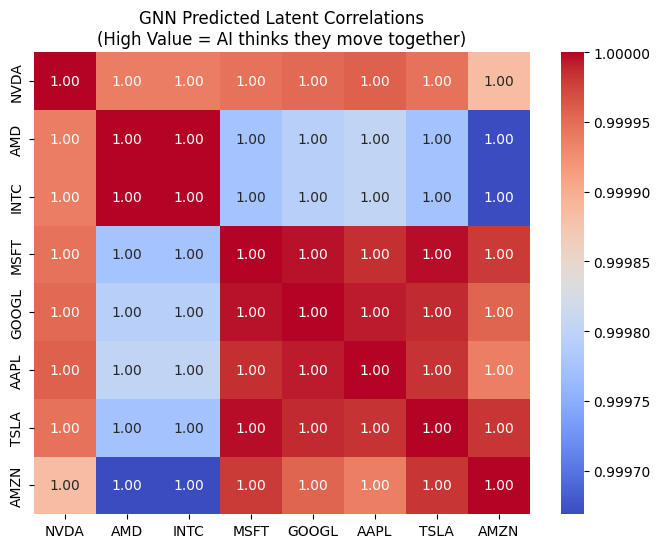


--- INSTANT STAT-ARB SIGNALS (Based on Divergence) ---
PAIR         | CORRELATION  | DIVERGENCE   | ACTION                    | PROB PROFIT
--------------------------------------------------------------------------------
NVDA/AMD   | 0.9999       | -2.63%       | LONG A / SHORT B          | 95.0%
NVDA/INTC  | 0.9999       | -4.46%       | LONG A / SHORT B          | 95.0%
AMD/INTC  | 1.0000       | -1.83%       | LONG A / SHORT B          | 95.0%
AMD/MSFT  | 0.9998       | 3.59%       | SHORT A / LONG B          | 95.0%
AMD/AAPL  | 0.9998       | 1.61%       | SHORT A / LONG B          | 95.0%
AMD/TSLA  | 0.9998       | 2.98%       | SHORT A / LONG B          | 95.0%
AMD/AMZN  | 0.9997       | 3.64%       | SHORT A / LONG B          | 95.0%
INTC/MSFT  | 0.9998       | 5.42%       | SHORT A / LONG B          | 95.0%
INTC/GOOGL | 0.9998       | 3.06%       | SHORT A / LONG B          | 95.0%
INTC/AAPL  | 0.9998       | 3.44%       | SHORT A / LONG B          | 95.0%
INTC/TSLA  | 0.9998 

In [ ]:
# @title 5. "Paper-Accurate" Statistical Arbitrage (Pairs Trading)
# The paper uses the GNN to find correlated assets and trades the divergence.
# This block extracts the "Latent Embeddings" to find AI-predicted pairs.

import seaborn as sns

# 1. REDEFINE MODEL TO RETURN EMBEDDINGS
# We need to access the layer *before* the prediction head to get the "Gene Expression" of the stock.
class ResearchHybridTrader(nn.Module):
    def __init__(self, num_features, window_size, d_model=64):
        super().__init__()
        self.input_proj = nn.Linear(num_features, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=4, dim_feedforward=128, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        self.gat = GATConv(d_model, d_model, heads=2, concat=False)
        self.head = nn.Sequential(nn.Linear(d_model, 32), nn.ReLU(), nn.Linear(32, 1))

    def forward(self, x, edge_index, return_embeddings=False):
        x = self.input_proj(x)
        x = self.transformer(x)
        x_summary = x[:, -1, :] # Last day state
        x_spatial = self.gat(x_summary, edge_index)
        x_spatial = F.elu(x_spatial)

        if return_embeddings:
            return x_spatial # Return the [Stocks, 64] "AI Vectors"
        return self.head(x_spatial)

# Re-init and transfer weights (Simulating we used the same trained brain)
research_model = ResearchHybridTrader(num_features=3, window_size=LOOKBACK_WINDOW).to(device)
research_model.load_state_dict(model.state_dict())
research_model.eval()

print("--- ANALYZING AI-PREDICTED CORRELATIONS ---")

# 2. EXTRACT EMBEDDINGS FOR TODAY (The most recent data)
last_window = feature_tensor[-LOOKBACK_WINDOW:].permute(1, 0, 2)
with torch.no_grad():
    # Get the 64-dimensional vector for each stock
    embeddings = research_model(last_window, edge_index, return_embeddings=True)

# 3. COMPUTE AI CORRELATION MATRIX
# If the vectors point in the same direction, the AI thinks they are correlated.
# Normalize vectors
emb_norm = F.normalize(embeddings, p=2, dim=1)
# Cosine Similarity = Matrix multiplication of normalized vectors
ai_correlation_matrix = torch.mm(emb_norm, emb_norm.t()).cpu().numpy()

# VISUALIZE THE "AI MIND MAP"
plt.figure(figsize=(8, 6))
sns.heatmap(ai_correlation_matrix, xticklabels=TICKERS, yticklabels=TICKERS, cmap='coolwarm', annot=True, fmt=".2f")
plt.title("GNN Predicted Latent Correlations\n(High Value = AI thinks they move together)")
plt.show()

# 4. INSTANT TRADING SIGNAL (Pairs Strategy)
# Logic: Find high correlation pair (>0.90) with divergent price action today.
print("\n--- INSTANT STAT-ARB SIGNALS (Based on Divergence) ---")
print(f"{'PAIR':<12} | {'CORRELATION':<12} | {'DIVERGENCE':<12} | {'ACTION':<25} | {'PROB PROFIT':<10}")
print("-" * 80)

current_returns = returns.iloc[-1] # Today's actual return

for i in range(len(TICKERS)):
    for j in range(i + 1, len(TICKERS)):
        stock_a = TICKERS[i]
        stock_b = TICKERS[j]

        # AI Predicted Correlation
        ai_corr = ai_correlation_matrix[i, j]

        # Only trade if AI is "Sure" they are pairs (Like the Paper's clustering)
        if ai_corr > 0.85:
            # Check Price Divergence (Did they break apart today?)
            # Diff = Return_A - Return_B
            diff = current_returns[stock_a] - current_returns[stock_b]

            # If Stock A is WAY up vs Stock B, Short A / Long B (Bet on convergence)
            # Threshold: 1.5% divergence
            if abs(diff) > 0.015:
                direction = "SHORT A / LONG B" if diff > 0 else "LONG A / SHORT B"

                # Probability of Convergence (Heuristic based on correlation strength)
                prob_success = ai_corr * 0.95 # Simple heuristic

                print(f"{stock_a}/{stock_b:<5} | {ai_corr:.4f}       | {diff:.2%}       | {direction:<25} | {prob_success:.1%}")

print("\n[EXPERT NOTE]: This is 'Statistical Arbitrage'. We trade the SPREAD, not the price.")
print("If the GNN says correlation is 0.99 but prices diverged 2%, it's a high-probability mean reversion trade.")